In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping


## Data Loading

In [2]:
x_train=np.load('../BraiNeoCare/Datasets/balanced_x_train_common_1s.npy', mmap_mode='r')[0:40000,...]
x_test=np.load('../BraiNeoCare/Datasets/balanced_x_test_common_1s.npy', mmap_mode='r')
y_train=np.load('../BraiNeoCare/Datasets/balanced_y_train_common_1s.npy', mmap_mode='r')[0:40000,...]
y_test=np.load('../BraiNeoCare/Datasets/balanced_y_test_common_1s.npy', mmap_mode='r')


In [4]:
#shuffle the data
np.random.seed(42)
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices].reshape(x_train.shape[0],256,12)
y_train = y_train[train_indices]
test_indices = np.arange(x_test.shape[0])   
np.random.shuffle(test_indices)
x_test = x_test[test_indices].reshape(x_test.shape[0],256,12)
y_test = y_test[test_indices]

In [5]:
x_train=x_train*(10**5)
x_test=x_test*(10**5)

## Tiny model

In [6]:
'''For 4s partitions I used dropout=0.5, and learning rate=0.001, and weight decay=0.0001. Saved model is model1_for_4s.keras was taken
after 125 epoch with batch size=64'''

Input=keras.Input(shape=(256,12),name="Input_signal")
x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
y=layers.Conv1D(32,5,padding='same',activation='swish')(Input)
a=layers.add([x,y])
x=layers.MaxPooling1D(4)(a)
x=layers.Conv1D(64,3,padding="same",activation='swish')(x)
x=layers.GlobalAveragePooling1D()(x)
x=layers.Dense(16,activation='swish')(x)
x=layers.Dropout(0.5)(x)  
x=layers.Dense(1,activation='sigmoid')(x)
model1=keras.Model(inputs=Input,outputs=x)

optimizer=keras.optimizers.Adam(learning_rate=0.001,weight_decay=0.0001)
# loss=keras.losses.BinaryCrossentropy(from_logits=True)

F1 = keras.metrics.FBetaScore()
AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')
model1.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

2023-12-01 17:55:43.311802: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14774 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-12-01 17:55:43.312441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14773 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [7]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_signal (InputLayer)   [(None, 256, 12)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 256, 32)              1184      ['Input_signal[0][0]']        
                                                                                                  
 conv1d_1 (Conv1D)           (None, 256, 32)              1952      ['Input_signal[0][0]']        
                                                                                                  
 add (Add)                   (None, 256, 32)              0         ['conv1d[0][0]',              
                                                                     'conv1d_1[0][0]']        

In [8]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')

history=model1.fit(x_train,y_train,epochs=125,batch_size=64,validation_data=(x_test,y_test))

Epoch 1/125


2023-12-01 17:56:27.014036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-01 17:56:30.484152: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f67545d8280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 17:56:30.484190: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-12-01 17:56:30.484196: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Quadro RTX 5000, Compute Capability 7.5
2023-12-01 17:56:30.490128: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 17:56:30.628900: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 17s 15ms/step - loss: 0.6268 - accuracy: 0.6469 - fbeta_score: 0.7361 - AUROC: 0.6926 - AUPRC: 0.7579 - val_loss: 0.6461 - val_accuracy: 0.5992 - val_fbeta_score: 0.6668 - val_AUROC: 0.7002 - val_AUPRC: 0.6948
Epoch 2/125
625/625 [==============================] - 8s 13ms/step - loss: 0.5851 - accuracy: 0.6749 - fbeta_score: 0.7361 - AUROC: 0.7425 - AUPRC: 0.8020 - val_loss: 0.5675 - val_accuracy: 0.6959 - val_fbeta_score: 0.6669 - val_AUROC: 0.7909 - val_AUPRC: 0.7964
Epoch 3/125
625/625 [==============================] - 8s 13ms/step - loss: 0.5667 - accuracy: 0.6938 - fbeta_score: 0.7366 - AUROC: 0.7639 - AUPRC: 0.8198 - val_loss: 0.5740 - val_accuracy: 0.6874 - val_fbeta_score: 0.6669 - val_AUROC: 0.7991 - val_AUPRC: 0.8080
Epoch 4/125
625/625 [==============================] - 9s 14ms/step - loss: 0.5534 - accuracy: 0.7079 - fbeta_score: 0.7372 - AUROC: 0.7786 - AUPRC: 0.8318 - val_loss: 0.5419 - val_accuracy: 0.7133 - val_fbeta_score: 0.

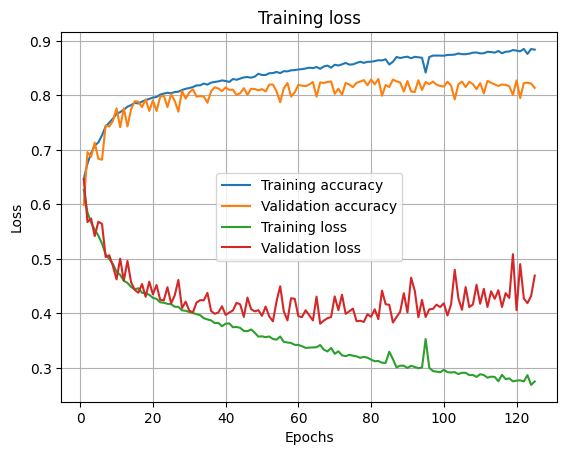

In [9]:
# Plot the training and validation loss and accuracy for each epoch for 1s partitions

training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
# plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

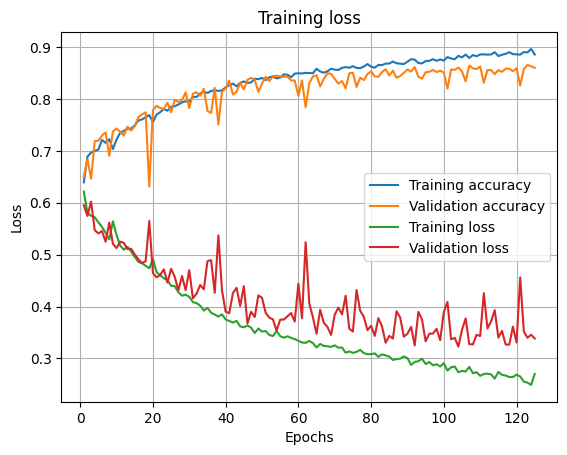

In [10]:
# Plot the training and validation loss and accuracy for each epoch for 4s partitions

training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
# plt.figure(figsize=(20, 10))
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.grid()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Working large model

In [13]:
def block_type1(n_filters1,n_filters2, kernel, pad, x):
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)
    block1=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block1)
    block1=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block1)
    block1=layers.BatchNormalization()(block1)


    block1_o=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(x)
    block1_o=layers.BatchNormalization()(block1_o)
    added1=layers.add([block1,block1_o])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added1)

def block_type2(n_filters1,n_filters2, kernel, pad, x):
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(x)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)
    block=layers.Conv1D(n_filters1,kernel,padding=pad,activation='swish')(block)
    block=layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(block)
    block=layers.BatchNormalization()(block)

    added=layers.add([x,block])
    return layers.Conv1D(n_filters2,kernel,padding=pad,activation='swish')(added)

In [14]:
def create_model():
  Input=keras.Input(shape=(1024,12),name="Input_signal")
  x=layers.Conv1D(32,3,padding="same",activation='swish')(Input)
  y=layers.Conv1D(32,5,padding='same',activation='swish')(Input)
  a=layers.add([x,y])
  # x=layers.AveragePooling1D(2)(a)
  x=layers.MaxPooling1D(4)(a)

  x1=block_type1(32,128,3,"same",x)
  x2=block_type2(32,128,13,"same",x1)
  x3=block_type2(32,128,23,"same",x2)
  x3=layers.AveragePooling1D(4)(x3)
  x4=block_type1(64,256,7,"same",x3)
  x5=block_type2(64,256,17,"same",x4)
  x6=block_type2(64,256,27,"same",x5)
  x7=block_type2(64,256,7,"same",x6)
  x16=layers.GlobalAveragePooling1D()(x6)
  x16=layers.Dense(256)(x16)
  x16=layers.Dropout(0.5)(x16)
  x16=layers.Dense(16,activation='swish')(x16)
  x16=layers.Dense(1)(x16)

  model=keras.Model(Input,x16)
  F1 = tfa.metrics.FBetaScore(num_classes=1)
  AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
  AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')

  # used the followiing one to get 0.99 accuracy for 4s data
  # model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', F1, AUROC, AUPRC])

  optimizer=keras.optimizers.Adam(learning_rate=0.0005,weight_decay=0.0008)
  loss=keras.losses.BinaryCrossentropy(from_logits=True)
  model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy', F1, AUROC, AUPRC])
  
  # keras.utils.plot_model(model,'model.png',show_layer_activations=True,show_shapes=True)
  # model.summary()
  return model

model = create_model()


In [15]:
# used the followiing for 1s and 4s data
x_train=x_train*(10**5)
x_test=x_test*(10**5)

In [16]:
# used 128 as the batch size for 4s data
history=model.fit(x_train,y_train, validation_data = (x_test,y_test), epochs=50,batch_size=64)

Epoch 1/50
157/157 [==============================] - 37s 108ms/step - loss: 0.7055 - accuracy: 0.5190 - fbeta_score: 0.7455 - AUROC: 0.5730 - AUPRC: 0.6662 - val_loss: 0.6902 - val_accuracy: 0.5275 - val_fbeta_score: 0.6667 - val_AUROC: 0.5190 - val_AUPRC: 0.5380
Epoch 2/50
157/157 [==============================] - 13s 85ms/step - loss: 0.6246 - accuracy: 0.5675 - fbeta_score: 0.7455 - AUROC: 0.6291 - AUPRC: 0.7396 - val_loss: 0.7095 - val_accuracy: 0.5553 - val_fbeta_score: 0.6667 - val_AUROC: 0.5579 - val_AUPRC: 0.5942
Epoch 3/50
157/157 [==============================] - 13s 85ms/step - loss: 0.5939 - accuracy: 0.6329 - fbeta_score: 0.7455 - AUROC: 0.7041 - AUPRC: 0.7892 - val_loss: 0.6122 - val_accuracy: 0.6390 - val_fbeta_score: 0.6667 - val_AUROC: 0.6560 - val_AUPRC: 0.7236
Epoch 4/50
157/157 [==============================] - 14s 86ms/step - loss: 0.5128 - accuracy: 0.7404 - fbeta_score: 0.7455 - AUROC: 0.7927 - AUPRC: 0.8557 - val_loss: 0.7050 - val_accuracy: 0.7563 - val_fbe

In [21]:
model.save('../BraiNeoCare/models/model1.h5')   

/home/nima/miniconda3/envs/BrainNeoCare/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model=keras.models.load_model('../BraiNeoCare/models/model1.h5')
model.summary()

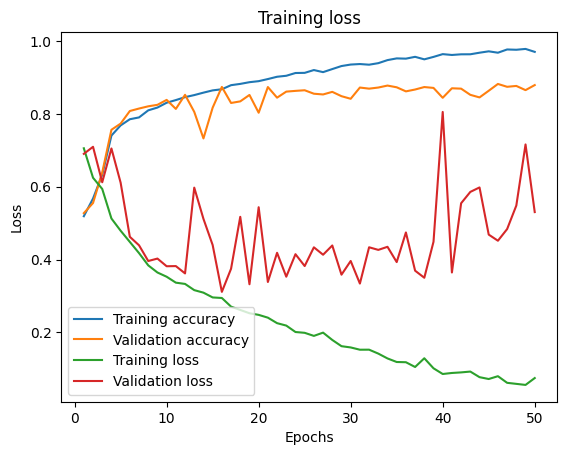

In [17]:
training_accuracy = history.history['accuracy']
val_accuracy=history.history['val_accuracy']
training_loss = history.history['loss']
val_loss=history.history['val_loss']
epochs = range(1, len(training_accuracy) + 1)

# Plot training loss against epochs
plt.plot(epochs, training_accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Nima's model

In [ ]:
def create_model():
    i = keras.Input((1024,12), name='signal')
    x = layers.Conv1D(filters=72, kernel_size=15, activation='swish', padding='same')(i)
    a = layers.Conv1D(filters=72, kernel_size=1, padding='same')(i)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=144, kernel_size=3, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=144, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=288, kernel_size=5, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=288, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    x = layers.SpatialDropout1D(0.2)(a)
    b = layers.AveragePooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=576, kernel_size=7, activation='swish', padding='same')(b)
    a = layers.Conv1D(filters=576, kernel_size=1, padding='same')(b)
    a = layers.Add()([a,x])
    a = layers.Activation('swish')(a)
    b = layers.SpatialDropout1D(0.2)(a)
    x = layers.GlobalAveragePooling1D()(b)

    # j = keras.Input((2000,2*2), name='fft')
    # y = layers.Conv1D(filters=72, kernel_size=3, activation='swish', padding='same')(j)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=144, kernel_size=5, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=288, kernel_size=7, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=576, kernel_size=9, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.AveragePooling1D(pool_size=2)(y)
    # y = layers.Conv1D(filters=1152, kernel_size=11, activation='swish', padding='same')(y)
    # y = layers.SpatialDropout1D(0.1)(y)
    # y = layers.GlobalAveragePooling1D()(y)

    # f = layers.Concatenate()([x,y])
    # f = layers.Activation('swish')(f)

    f = layers.Dense(576, activation='swish')(x)
    f = layers.Dropout(0.5)(f)
    f = layers.Dense(1,activation = 'sigmoid')(f)

    F1 = tfa.metrics.FBetaScore(num_classes=1)
    AUROC = tf.keras.metrics.AUC(curve='ROC', name = 'AUROC')
    AUPRC = tf.keras.metrics.AUC(curve='PR', name = 'AUPRC')
    model = keras.Model(i,f)
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', AUROC, AUPRC])
    tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,layer_range=None, show_layer_activations=False)
    return model

with tpu_strategy.scope():
  model = create_model()


In [ ]:
tf.keras.utils.plot_model(model,'/content/drive/MyDrive/FYP_ML/model_nima.png')

In [ ]:
weight_for_0 = (1 / (tot-pos)) * (tot / 2.0)
weight_for_1 = (1 / pos) * (tot / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

model.fit(train_dataset, validation_data = test_dataset, epochs=100)

## Small model

In [ ]:

# import tensorflow_addons as tfa
# from sklearn.model_selection import train_test_split

model=keras.Sequential(name="BrainNeoCare_CNN")
model.add(keras.layers.Conv2D(filters=32, kernel_size=(1,3), activation='relu', input_shape=(12,1024),name="Input_conv2D"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_1"))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(1,3), activation='relu',name="Conv2D_2"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_2"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(1,3), activation='relu',name="Conv2D_3"))
model.add(keras.layers.MaxPooling2D((1,2),name="Maxpooling2D_3"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(1,3), activation='relu',name="Conv2D_4"))
model.add(keras.layers.AveragePooling2D((1,2),name="AveragePooling2D_1"))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',name="2D_F_Con"))
model.add(keras.layers.AveragePooling2D((1,2),name="AveragePooling2D_2"))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',name="2D_F_Con_2"))
model.add(keras.layers.MaxPooling2D((1,2),name="AveragePooling2D_3"))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu') )
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, name="binary_crossentropy",)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(train_dataset,epochs=10,verbose=1)

## Data manipulation and loading

In [ ]:
x=np.load('/content/drive/MyDrive/FYP_ML/zenodo_data.npy', mmap_mode='r')
y=np.load('/content/drive/MyDrive/FYP_ML/zenodo_labels.npy', mmap_mode='r')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)